In [1]:
# Внимание!!! Важно, что бы файлы с данными и исполняемый файл находились в одной папке, 
# тогда пути к тестовым и тренировочным наборам будут содержать только имена файлов.
# 
# В пути к тренировочным и тестовым данным запрежается использовать абсалютную адресацию, 
# то есть адресацию, в которой присутствуют имена папок. Путь должен содержать только имя файла.
#
# Напоминание: под моделью машинного обучения понимаются все действия с исходными данными, 
# которые необходимо произвести, что бы сопоставить признаки целевому значению.

### Область работы 1 (библиотеки)

In [2]:
# Данный блок в области 1 НЕ выполняется преподавателем
# 
# данный блок предназначен только для подключения необходимых библиотек
# запрещается подключать библиотеки в других блоках
# запрещается скрывать предупреждения системы
# установка дополнительных библиотек размещается прямо здесь (обязательно закоментированы)
# pip install

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import RobustScaler, Normalizer

from sklearn.model_selection import train_test_split, cross_val_score  
from sklearn.model_selection import GridSearchCV, KFold, StratifiedShuffleSplit
from sklearn.model_selection import ShuffleSplit

from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 

from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report

import sklearn
print(sklearn.__version__)

1.3.1


### Область работы 2 (поиск  модели .... )

In [4]:
# Данный блок(и) НЕ выполняются преподавателем в области 2
# блок(и) предназначены для поиска лучшей модели 
# должен быть понятен и очевиден отбор параметров модели
# оставляйте свои комментарии и разъяснения
# 
# Запрещается размещать данные блоки за пределами обасти 2
# Все блоки данной области должны быть выполнены
#
# ЗАПРЕЩАЕТСЯ ИСПОЛЬЗОВАТЬ ТЕСТОВЫЙ НАБОР
#
# Путь к тренировочному набору
# 

path_train = ... # содержит только имя файла, без имен папок !!!

### Заведем данные, посмотрим на наличие пропущенных заначений и уберем дубликаты


In [5]:
path_train = 'train.csv'

df = pd.read_csv(path_train)
df.head()
df.info()                 #проверяем есть ли пропущенные данные (в нашем случае их нет)
df.describe()
df = df.drop_duplicates() #убираем строки-дубликаты

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1725 entries, 0 to 1724
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1725 non-null   float64
 1   volatile acidity      1725 non-null   float64
 2   citric acid           1725 non-null   float64
 3   residual sugar        1725 non-null   float64
 4   chlorides             1725 non-null   float64
 5   free sulfur dioxide   1725 non-null   float64
 6   total sulfur dioxide  1725 non-null   float64
 7   density               1725 non-null   float64
 8   pH                    1725 non-null   float64
 9   sulphates             1725 non-null   float64
 10  alcohol               1725 non-null   float64
 11  quality               1725 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 161.8 KB


### Так как мы решаем задачу классификации, то разделим все вина на два класса: вина с качеством меньше 7 мы обозначим за 0, так как у них отсутсвует признак "хорошего качества", а вина с качеством больше 7 мы обозначим за 1, так как у них "хорошее качество" присутсвует. 

In [6]:
df["Q"] = np.where(df['quality'] < 7, 0, 1) #т.к. мы решаем задачу классификации
df = df.drop(columns = ["quality"])
y = df.Q
X = df.iloc[:,:-1].values

### Сплитуем наши данные и вводим стратификацию по y, чтобы данные делились равносильно их соотношению в всем наборе данных. 

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y)

Проверяем, что все данные у нас находятся в формате массива

In [8]:
X

array([[ 6.4 ,  0.17,  0.34, ...,  3.25,  0.49,  9.6 ],
       [ 8.  ,  0.42,  0.36, ...,  3.13,  0.57, 12.3 ],
       [ 6.7 ,  0.27,  0.25, ...,  3.22,  0.43,  9.3 ],
       ...,
       [ 7.  ,  0.53,  0.43, ...,  3.08,  0.5 , 12.5 ],
       [ 5.9 ,  0.17,  0.29, ...,  3.41,  0.33, 13.7 ],
       [ 5.5 ,  0.34,  0.26, ...,  3.55,  0.49, 13.  ]])

In [9]:
X_test.shape

(863, 11)

# Строим модели с помощью 3 мотодов: метода ближайших соседей, наивного байесовского метода и метода логистической регрессии

## Строим модель методом ближайших соседей

In [10]:
pipe_1 = Pipeline([('preprocessing', RobustScaler()), 
                 ('classifier', KNeighborsClassifier())])

shuffle_split = ShuffleSplit(test_size = .3, train_size = .6, n_splits = 5, random_state = 42)

n_neighbors = [10, 25, 50, 70, 90]
p = [1,4,8,20,40,50,70]
weights=['uniform', 'distance']
scaling = [ MinMaxScaler(), StandardScaler(),RobustScaler(), Normalizer()]

param_grid =[
    {'preprocessing': scaling, 
     'classifier': [KNeighborsClassifier()],
     'classifier__n_neighbors': n_neighbors,
     'classifier__p': p,
     'classifier__weights': weights,
     'classifier__n_jobs' : [-1]
     }
]

grid = GridSearchCV(pipe_1, param_grid, cv = shuffle_split, return_train_score=True, scoring = 'precision')
grid.fit(X_train, y_train)
grid

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=0.3, train_size=0.6),
             estimator=Pipeline(steps=[('preprocessing', RobustScaler()),
                                       ('classifier', KNeighborsClassifier())]),
             param_grid=[{'classifier': [KNeighborsClassifier()],
                          'classifier__n_jobs': [-1],
                          'classifier__n_neighbors': [10, 25, 50, 70, 90],
                          'classifier__p': [1, 4, 8, 20, 40, 50, 70],
                          'classifier__weights': ['uniform', 'distance'],
                          'preprocessing': [MinMaxScaler(), StandardScaler(),
                                            RobustScaler(), Normalizer()]}],
             return_train_score=True, scoring='precision')

In [11]:
grid_result = pd.DataFrame(grid.cv_results_).sort_values(["rank_test_score",'std_test_score']).T
grid_result

,249,257,233,253,33,241,265,153,161,245,...,259,171,250,175,235,115,7,59,227,231
mean_fit_time,0.00104,0.001083,0.001164,0.001086,0.001031,0.00108,0.001043,0.001069,0.001069,0.001069,...,0.001018,0.000998,0.002127,0.001095,0.001102,0.001001,0.001334,0.001068,0.001009,0.001044
std_fit_time,0.000008,0.000015,0.000027,0.000007,0.000011,0.000012,0.000014,0.000009,0.000011,0.000009,...,0.000043,0.000013,0.000019,0.000033,0.000017,0.000019,0.000039,0.000059,0.000007,0.000014
mean_score_time,0.018493,0.01905,0.019185,0.015824,0.019562,0.019072,0.019196,0.019644,0.019394,0.015178,...,0.019976,0.019769,0.018216,0.016399,0.019867,0.019694,0.01652,0.019729,0.019817,0.016482
std_score_time,0.000772,0.000934,0.000918,0.00074,0.00036,0.000834,0.00068,0.000228,0.000073,0.000746,...,0.000403,0.000189,0.000953,0.000113,0.000538,0.000212,0.000161,0.001275,0.00009,0.000099
param_classifier,KNeighborsClassifier(),KNeighborsClassifier(),KNeighborsClassifier(),KNeighborsClassifier(),KNeighborsClassifier(),KNeighborsClassifier(),KNeighborsClassifier(),KNeighborsClassifier(),KNeighborsClassifier(),KNeighborsClassifier(),...,KNeighborsClassifier(),KNeighborsClassifier(),KNeighborsClassifier(),KNeighborsClassifier(),KNeighborsClassifier(),KNeighborsClassifier(),KNeighborsClassifier(),KNeighborsClassifier(),KNeighborsClassifier(),KNeighborsClassifier()
param_classifier__n_jobs,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
param_classifier__n_neighbors,90,90,90,90,10,90,90,50,50,90,...,90,70,90,70,90,50,10,25,90,90
param_classifier__p,20,40,4,20,40,8,50,50,70,8,...,40,1,20,1,4,1,1,1,1,1
param_classifier__weights,uniform,uniform,uniform,distance,uniform,uniform,uniform,uniform,uniform,distance,...,uniform,uniform,uniform,distance,uniform,uniform,distance,uniform,uniform,distance
param_preprocessing,StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),...,Normalizer(),Normalizer(),RobustScaler(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer()


### Выводим параметры модели с наилучшими результатами

In [12]:
print(grid.best_estimator_)

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('classifier',
                 KNeighborsClassifier(n_jobs=-1, n_neighbors=90, p=20))])


### Записываем нашу модель с полученными лучшими результатами

In [13]:
pipe_1 = Pipeline([('preprocessing', StandardScaler()),
                ('classifier',
                 KNeighborsClassifier(n_jobs=-1, n_neighbors=70, p=4,
                                      weights='uniform'))])
pipe_1.fit(X_train, y_train)

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('classifier',
                 KNeighborsClassifier(n_jobs=-1, n_neighbors=70, p=4))])

In [14]:
pipe_1.fit(X_train,y_train)
y_pred_1 = pipe_1.predict(X_test)

## Строим модель наивным байесовским методом

In [15]:
pipe_2 = Pipeline([('preprocessing', MinMaxScaler()), 
                 ('clf',           GaussianNB())])

cv = StratifiedShuffleSplit(test_size = .3, train_size = .6, n_splits = 5, random_state = 42)
scaling = [ MinMaxScaler(), StandardScaler(),RobustScaler(), Normalizer()]
wh = [GaussianNB(), BernoulliNB()]
param_grid =[
    {'preprocessing': scaling, 
     'clf': wh}
    ]

grid = GridSearchCV(pipe_2, param_grid, cv = shuffle_split, return_train_score=True, scoring = 'precision')
grid.fit(X_train, y_train)
grid 

/Users/daria_otradnova/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daria_otradnova/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daria_otradnova/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daria_otradnova/opt/anaconda3/lib/python3.9/s

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=0.3, train_size=0.6),
             estimator=Pipeline(steps=[('preprocessing', MinMaxScaler()),
                                       ('clf', GaussianNB())]),
             param_grid=[{'clf': [GaussianNB(), BernoulliNB()],
                          'preprocessing': [MinMaxScaler(), StandardScaler(),
                                            RobustScaler(), Normalizer()]}],
             return_train_score=True, scoring='precision')

In [16]:
grid_result = pd.DataFrame(grid.cv_results_).sort_values(["rank_test_score",'std_test_score']).T
grid_result

,6,5,0,1,2,4,3,7
mean_fit_time,0.002239,0.001139,0.001113,0.000938,0.001991,0.001128,0.000856,0.001035
std_fit_time,0.000043,0.00001,0.000466,0.000014,0.000045,0.000208,0.000014,0.000011
mean_score_time,0.001243,0.001225,0.001238,0.001186,0.001168,0.001334,0.00124,0.001299
std_score_time,0.000009,0.000006,0.000129,0.000047,0.000002,0.000204,0.000004,0.000007
param_clf,BernoulliNB(),BernoulliNB(),GaussianNB(),GaussianNB(),GaussianNB(),BernoulliNB(),GaussianNB(),BernoulliNB()
param_preprocessing,RobustScaler(),StandardScaler(),MinMaxScaler(),StandardScaler(),RobustScaler(),MinMaxScaler(),Normalizer(),Normalizer()
params,"{'clf': BernoulliNB(), 'preprocessing': Robust...","{'clf': BernoulliNB(), 'preprocessing': Standa...","{'clf': GaussianNB(), 'preprocessing': MinMaxS...","{'clf': GaussianNB(), 'preprocessing': Standar...","{'clf': GaussianNB(), 'preprocessing': RobustS...","{'clf': BernoulliNB(), 'preprocessing': MinMax...","{'clf': GaussianNB(), 'preprocessing': Normali...","{'clf': BernoulliNB(), 'preprocessing': Normal..."
split0_test_score,0.560748,0.566038,0.579365,0.579365,0.579365,0.0,0.473333,0.0
split1_test_score,0.580645,0.59375,0.622378,0.622378,0.622378,0.857143,0.557823,0.0
split2_test_score,0.616822,0.610619,0.591304,0.591304,0.591304,0.8,0.396341,0.0


### Выводим параметры модели с наилучшими результатами

In [17]:
print(grid.best_estimator_)

Pipeline(steps=[('preprocessing', RobustScaler()), ('clf', BernoulliNB())])


### Записываем нашу модель с полученными лучшими результатами

In [18]:
pipe_2 = Pipeline([('preprocessing', RobustScaler()),
                ('clf',BernoulliNB())])
pipe_2.fit(X_train, y_train)
y_pred_2 = pipe_2.predict(X_test)

## Строим модель методом логистической регрессии

In [19]:
pipe_3 = Pipeline([('preprocessing', MinMaxScaler()), 
                 ('clf',           LogisticRegression())])

# n_splits = 5, random_state = 42 дают не улачную комбинацию и это хорошо для разбора ошибок решетки
cv = StratifiedShuffleSplit(test_size = .3, train_size = .6, n_splits = 5, random_state = 42)
scaling = [ MinMaxScaler(), StandardScaler(),RobustScaler(), Normalizer()]

param_grid =[
    {'preprocessing': scaling,'clf__penalty': ['l2'], 
         'clf__solver': ['newton-cg' ,'lbfgs', 'liblinear', 'sag', 'saga']},
    {'preprocessing': scaling,'clf__penalty': ['l1'], 
         'clf__solver': ['liblinear']},
    {'preprocessing': scaling,'clf__penalty': ['none'], 
         'clf__solver': ['lbfgs','newton-cg']}
    ]

grid = GridSearchCV(pipe_3, param_grid, cv = shuffle_split, return_train_score=True, scoring = 'precision')
grid.fit(X_train, y_train)
grid    

/Users/daria_otradnova/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daria_otradnova/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daria_otradnova/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daria_otradnova/opt/anaconda3/lib/python3.9/s

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=0.3, train_size=0.6),
             estimator=Pipeline(steps=[('preprocessing', MinMaxScaler()),
                                       ('clf', LogisticRegression())]),
             param_grid=[{'clf__penalty': ['l2'],
                          'clf__solver': ['newton-cg', 'lbfgs', 'liblinear',
                                          'sag', 'saga'],
                          'preprocessing': [MinMaxScaler(), StandardScaler(),
                                            RobustScaler(), Normalizer()]},
                         {'clf__penalty': ['l1'], 'clf__solver': ['liblinear'],
                          'preprocessing': [MinMaxScaler(), StandardScaler(),
                                            RobustScaler(), Normalizer()]},
                         {'clf__penalty': ['none'],
                          'clf__solver': ['lbfgs', 'newton-cg'],
                          'preprocessing': [MinMaxScaler(), StandardScaler(),
                                            RobustScaler(), Normalizer()]}],
             return_train_score=True, scoring='precision')

In [20]:
grid_result = pd.DataFrame(grid.cv_results_).sort_values(["rank_test_score",'std_test_score']).T
grid_result

,27,24,25,26,28,29,30,2,6,10,...,17,20,22,21,3,7,15,19,23,11
mean_fit_time,0.014517,0.006065,0.003232,0.004296,0.011591,0.007217,0.008861,0.011557,0.004117,0.002671,...,0.004937,0.005639,0.00294,0.002284,0.005928,0.004249,0.002012,0.001889,0.026317,0.001188
std_fit_time,0.003822,0.000502,0.000602,0.000134,0.002346,0.00224,0.001358,0.001944,0.000166,0.000293,...,0.001591,0.001935,0.000708,0.000694,0.001174,0.000712,0.000039,0.000081,0.016244,0.000025
mean_score_time,0.001287,0.001198,0.00119,0.001206,0.001332,0.001278,0.001237,0.001498,0.001202,0.001204,...,0.001098,0.001093,0.001105,0.001096,0.001383,0.0013,0.001187,0.001193,0.001257,0.00128
std_score_time,0.00001,0.000019,0.000015,0.000011,0.000095,0.000088,0.000058,0.000308,0.000002,0.000027,...,0.000009,0.000004,0.000003,0.000002,0.000076,0.000029,0.000013,0.000012,0.000092,0.000044
param_clf__penalty,none,none,none,none,none,none,none,l2,l2,l2,...,l2,l1,l1,l1,l2,l2,l2,l2,l1,l2
param_clf__solver,lbfgs,lbfgs,lbfgs,lbfgs,newton-cg,newton-cg,newton-cg,newton-cg,lbfgs,liblinear,...,saga,liblinear,liblinear,liblinear,newton-cg,lbfgs,sag,saga,liblinear,liblinear
param_preprocessing,Normalizer(),MinMaxScaler(),StandardScaler(),RobustScaler(),MinMaxScaler(),StandardScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),...,StandardScaler(),MinMaxScaler(),RobustScaler(),StandardScaler(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer()
params,"{'clf__penalty': 'none', 'clf__solver': 'lbfgs...","{'clf__penalty': 'none', 'clf__solver': 'lbfgs...","{'clf__penalty': 'none', 'clf__solver': 'lbfgs...","{'clf__penalty': 'none', 'clf__solver': 'lbfgs...","{'clf__penalty': 'none', 'clf__solver': 'newto...","{'clf__penalty': 'none', 'clf__solver': 'newto...","{'clf__penalty': 'none', 'clf__solver': 'newto...","{'clf__penalty': 'l2', 'clf__solver': 'newton-...","{'clf__penalty': 'l2', 'clf__solver': 'lbfgs',...","{'clf__penalty': 'l2', 'clf__solver': 'libline...",...,"{'clf__penalty': 'l2', 'clf__solver': 'saga', ...","{'clf__penalty': 'l1', 'clf__solver': 'libline...","{'clf__penalty': 'l1', 'clf__solver': 'libline...","{'clf__penalty': 'l1', 'clf__solver': 'libline...","{'clf__penalty': 'l2', 'clf__solver': 'newton-...","{'clf__penalty': 'l2', 'clf__solver': 'lbfgs',...","{'clf__penalty': 'l2', 'clf__solver': 'sag', '...","{'clf__penalty': 'l2', 'clf__solver': 'saga', ...","{'clf__penalty': 'l1', 'clf__solver': 'libline...","{'clf__penalty': 'l2', 'clf__solver': 'libline..."
split0_test_score,0.714286,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.657895,0.657895,0.657895,...,0.653846,0.64,0.649351,0.64557,0.5,0.5,0.5,0.5,0.466667,0.333333
split1_test_score,0.697368,0.695122,0.695122,0.695122,0.695122,0.695122,0.695122,0.698795,0.698795,0.698795,...,0.698795,0.7125,0.696203,0.696203,0.0,0.0,0.0,0.0,0.230769,0.0


### Выводим параметры модели с наилучшими результатами

In [21]:
print(grid.best_estimator_)

Pipeline(steps=[('preprocessing', Normalizer()),
                ('clf', LogisticRegression(penalty='none'))])


### Записываем нашу модель с полученными лучшими результатами

In [22]:
pipe_3 = Pipeline([('preprocessing', MinMaxScaler()),
                ('clf',LogisticRegression(penalty=None, solver='newton-cg'))])
pipe_3.fit(X_train, y_train)
y_pred_3 = pipe_3.predict(X_test)

### Построим кривую ROC AUC (чем больше площадь под нашей кривой, тем лучше)

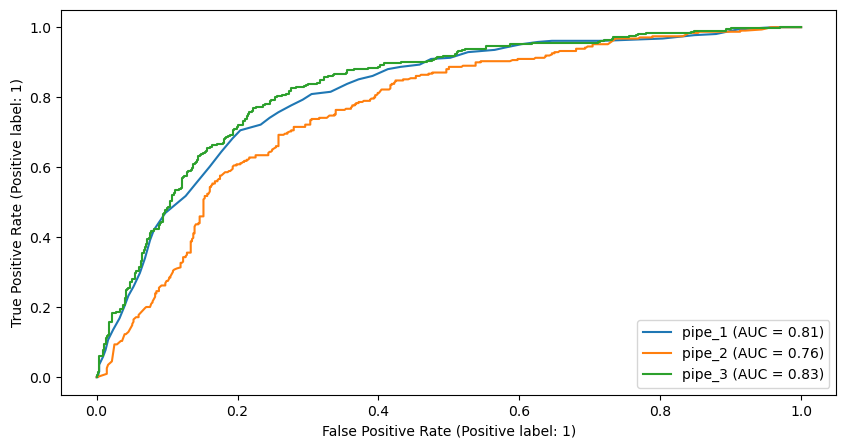

In [23]:
fig, ax_roc = plt.subplots(1,1, figsize=(10, 5))

RocCurveDisplay.from_estimator(pipe_1, X_test, y_test, ax = ax_roc, name = 'pipe_1');
RocCurveDisplay.from_estimator(pipe_2, X_test, y_test, ax = ax_roc, name = 'pipe_2');
RocCurveDisplay.from_estimator(pipe_3, X_test, y_test, ax = ax_roc, name = 'pipe_3');

### Построим матрицы ошибок и сравним все три, полученные разными методами, модели. 


Нам важно, чтобы наименьшее количество вин "плохого" качества определялись, как "хорошие" (т.е. чтобы вина 0 класса не определялись как вина 1 класса), чтобы мы не смогли их "случайно купить", однако сколько "хороших" вин определяются как "плохие" нам не сильно важно. 

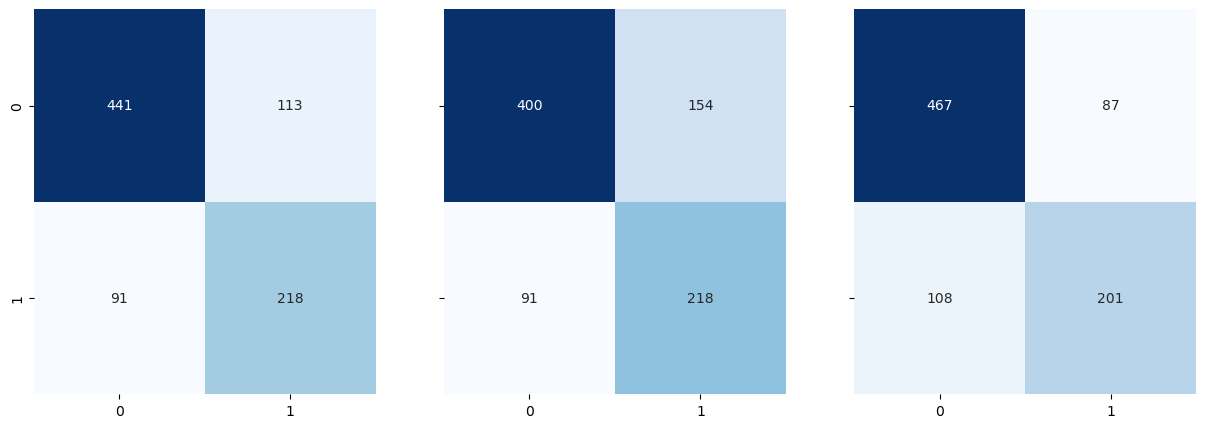

In [24]:
matrix_1 = confusion_matrix(y_test,y_pred_1)
matrix_2 = confusion_matrix(y_test,y_pred_2)
matrix_3 = confusion_matrix(y_test,y_pred_3)


fig,ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15,5))
ax = plt.subplot(1, 3, 1)
sns.heatmap(matrix_1,annot=True, fmt='g', cbar=None,cmap="Blues");
ax = plt.subplot(1, 3, 2)
sns.heatmap(matrix_2,annot=True, fmt='g', cbar=None,cmap="Blues");
ax = plt.subplot(1, 3, 3)
sns.heatmap(matrix_3,annot=True, fmt='g', cbar=None,cmap="Blues");

### Для наглядного сравнения выведем результаты моделей

In [25]:
print("Тренировка:", pipe_1.score(X_train, y_train), "Тест:", pipe_1.score(X_test, y_test) )
print("Тренировка:", pipe_2.score(X_train, y_train), "Тест:", pipe_2.score(X_test, y_test) )
print("Тренировка:", pipe_3.score(X_train, y_train), "Тест:", pipe_3.score(X_test, y_test) )

Тренировка: 0.7703016241299304 Тест: 0.7636152954808807
Тренировка: 0.7122969837587007 Тест: 0.7161066048667439
Тренировка: 0.7529002320185615 Тест: 0.7740440324449595


### Вывод: проанализировав полученные данные мы можем сделать вывод, что наилучшей моделью является модель логистической регрессии, так как:
### 1. имеет наибольшую площадь под кривой ROC AUC
### 2. делает наименьшее количество ошибок (смотрим на матрицах ошибок) 
### 3. результат на тестовых значений самый высокий